In [1]:
import pickle
import os
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import time
from collections import deque
%matplotlib inline

## 1. Camera Calibration

In [2]:
class CameraCalibrator(object):
    
    def __init__(self):
        self.mtx = None
        self.dist = None
        
    
    def calibrate(self, chessboard_image_path):
        objpoints = [] # 3d points in real world space
        imgpoints = [] # 2d points in image plane
        
        images = glob.glob(os.path.join(chessboard_image_path, '*.jpg'))
        objp = np.zeros((6*9,3), np.float32)
        objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) # shape into two columns

        
        for fname in images:
            img = cv2.imread(fname)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # cv2.imread is BGR
            # findChessboardCorners
            ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
            
            if ret == True:
                objpoints.append(objp)
                imgpoints.append(corners)
            
        assert len(imgpoints) > 0, 'No corners found!'
        _, self.mtx, self.dist, _, _ = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    def undistort(self, image):
        return cv2.undistort(image, self.mtx, self.dist, None, self.mtx)
    
    def save_camera_coeff(self, fname='camera_calibration/camera_coeff'):
        camera_coeff = {} #dist
        camera_coeff['mtx'] = self.mtx
        camera_coeff['dist'] = self.dist
        with open(fname, 'wb') as f:
            pickle.dump(camera_coeff, f)
        print('Camera coefficients (mtx and dist) are saved to {}'.format(fname))
    
    def load_camera_coeff(self, fname='camera_calibration/camera_coeff'):
        with open(fname, 'rb') as f:
            camera_coeff = pickle.load(f)
            self.mtx = camera_coeff['mtx']
            self.dist = camera_coeff['dist']
        print('Camera coefficients (mtx and dist) are loaded from {}'.format(fname))

### Calibrate chessboard images

In [3]:
# Only need to run the first time
#camera_calibrator = CameraCalibrator()
#camera_calibrator.calibrate(chessboard_image_path = 'camera_cal/')
#camera_calibrator.save_camera_coeff()

In [4]:
camera_calibrator = CameraCalibrator()
camera_calibrator.load_camera_coeff()

Camera coefficients (mtx and dist) are loaded from camera_calibration/camera_coeff


### Visualization example 1

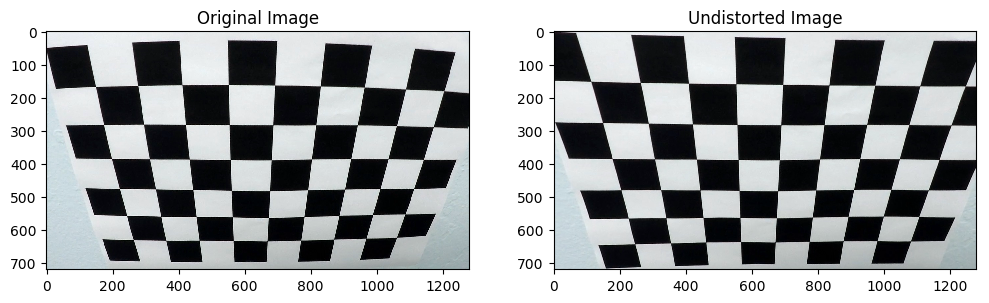

In [5]:
test_image = cv2.imread('camera_cal/calibration2.jpg')
test_undistort = camera_calibrator.undistort(test_image)
plt.figure(figsize=(12, 4), dpi=100)
plt.subplot(1,2,1)
plt.imshow(test_image)
plt.title('Original Image')
plt.subplot(1,2,2)
plt.imshow(test_undistort)
plt.title('Undistorted Image')

### Visualization example 2

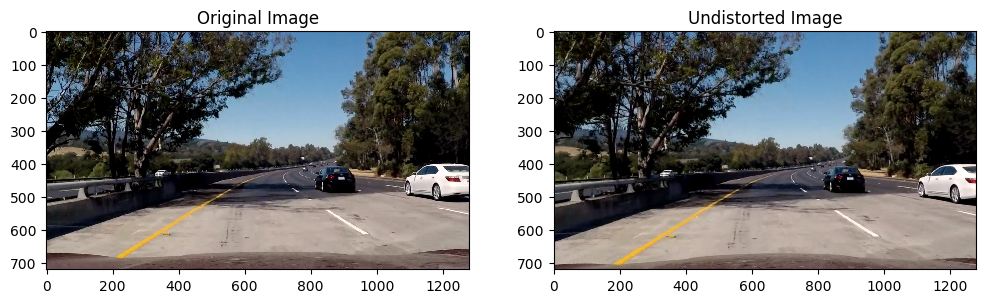

In [6]:
test_image = cv2.imread('test_images/test5.jpg')
test_undistort = camera_calibrator.undistort(test_image)
plt.figure(figsize=(12, 4), dpi=100)
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(test_undistort, cv2.COLOR_BGR2RGB))
plt.title('Undistorted Image')

## 2. Color Space and Image Filter

The filtering display bad result in HLS color space. Therefore, a good [reference](https://github.com/AlphaLFC/CarND-Advanced-Lane-Lines-P4/blob/master/Advanced-Lane-Lines-P4.ipynb) suggests that can use LAB color space instead.

In [7]:
class ImageFilter:
    """
    ImageFilter converts the image into different Color space (HLS or LAB) and operates Sobel on it.
    """
    def __init__(self):
        self.S_thresh = [170, 255] # saturation filter
        self.L_thresh = 170
        self.B_thresh = 60
        self.sobel_thresh = [20, 100]
        self.m_thresh = [30, 255]  # [magnitude_threshold_low, magnitude_threshold_high]
        self.g_thresh = [0.7, 1.3] # [gradient_threshold_low, gradient_threshold_high]
        
    def _BGR2HLS(self, image):
        """
        Convert the image to HLS color space
        """
        HLS = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
        return HLS
    
    def _BGR2LAB(self, image):
        """
        Convert the image to LAB color space
        """
        LAB = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        return LAB 
        
    def _sobel_absolute_with_gaussian_blur(self, gray_image, sobel_thresh ,kernel_size=3):
        """
        Apply sobel in both x and y direction. In addition, using gaussian smoothing
        """
        sobel_x = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=kernel_size)
        sobel_y = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=kernel_size)
        sobel_x_abs = np.absolute(sobel_x)
        sobel_y_abs = np.absolute(sobel_y)
        sobel_x_scaled = np.uint8(255 * sobel_x_abs/np.max(sobel_x_abs))
        sobel_y_scaled = np.uint8(255 * sobel_y_abs/np.max(sobel_y_abs))
        # Gaussian smoothing
        sobel_x_scaled = cv2.GaussianBlur(sobel_x_scaled, (kernel_size,)*2, kernel_size) #???
        sobel_y_scaled = cv2.GaussianBlur(sobel_y_scaled, (kernel_size,)*2, kernel_size)
        
        binary = np.zeros_like(gray_image)
        binary[ (sobel_x_scaled > sobel_thresh[0]) & (sobel_x_scaled < sobel_thresh[1]) & \
                (sobel_y_scaled > sobel_thresh[0]) & (sobel_y_scaled < sobel_thresh[1])] = 1
        return binary        
    
    def _sobel_magnitude(self, gray_image, m_thresh, kernel_size=3):
        """
        return a binary 
        """
        sobel_x = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=kernel_size)
        sobel_y = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=kernel_size)
        sobel_magnitude = np.sqrt((sobel_x)**2 + (sobel_y)**2)
        scaled_sobel = np.uint8(255 * sobel_magnitude/np.max(sobel_magnitude)) # re-sacle to [0, 255]
        binary_out = np.zeros_like(gray_image)
        binary_out[(scaled_sobel > m_thresh[0]) & (scaled_sobel < m_thresh[1])] = 1
        return binary_out
        
    def _sobel_gradient(self, gray_image, g_thresh, kernel_size=3):
        """
        return a binary
        """
        sobel_x = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=kernel_size)
        sobel_y = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=kernel_size)
        sobel_x_abs = np.absolute(sobel_x)
        sobel_y_abs = np.absolute(sobel_y)
        
        grad_direction = np.arctan2(sobel_y_abs, sobel_x_abs) # direction of graident
        binary_out = np.zeros_like(gray_image)
        binary_out[(grad_direction >= g_thresh[0]) & (grad_direction <= g_thresh[1])] = 1
        return binary_out
         
    def _sobel_filter(self, gray_image, m_thresh, g_thresh):
        """
        Apply sobel filter
        return a binary
        """
        m_binary = self._sobel_magnitude(gray_image, m_thresh)
        #g_bianry = self._sobel_gradient(gray_image, g_thresh)
        
        #combined_binary = np.zeros_like(gray_image)
        #combined_binary[(m_binary == 1) & (g_bianry == 1)] = 1
        
        return m_binary
    
    def _saturation_filter(self, image, S_thresh):
        """
        return a binary
        """
        # 1. BGR -> HLS
        HLS = self._BGR2HLS(image)
        S = HLS[:,:,2]
        
        binary = np.zeros_like(S)
        binary[(S > S_thresh[0]) & (S < S_thresh[1])] = 1
        
        return binary
        
    def _lab_filter(self, LAB_image, L_thresh, B_thresh):
        """
        Apply threshold on LAB color space and median filtering
        """
        L = LAB_image[:,:,0]
        B = LAB_image[:,:,2]
        
        #Median filtering
        median_L = np.int(np.median(L))
        median_B = np.int(np.median(B))
        
        L[L < median_L] = median_L
        B[B < median_B] = median_B
        
        # L channel thresh for white color extraction
        # B channel thresh for yellow color extraction
        L_scaled = (L - np.min(L)) * 255.0 / (np.max(L) - np.min(L))
        B_scaled = (B - np.min(B)) * 255.0 / (np.max(B) - np.min(B))
        binary = np.zeros_like(L)
        binary[L_scaled > L_thresh] = 1
        binary[B_scaled > B_thresh] = 1
        
        return binary
        
    def apply(self, image):
        """
        Currently only apply _lab_filter and _sobel_absolute_with_gaussian_blur
        """
        
        # 1. _lab_filter
        LAB = self._BGR2LAB(image)
        binary_lab = self._lab_filter(LAB, self.L_thresh, self.B_thresh)
        
        # 2. Sobel filter
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        sobel_binary = self._sobel_absolute_with_gaussian_blur(gray, self.sobel_thresh)
        
        combined_binary = np.zeros_like(gray)
        combined_binary[(binary_lab == 1) | (sobel_binary == 1)] = 1  # OR!
        
        return combined_binary

### Visualization of image filter

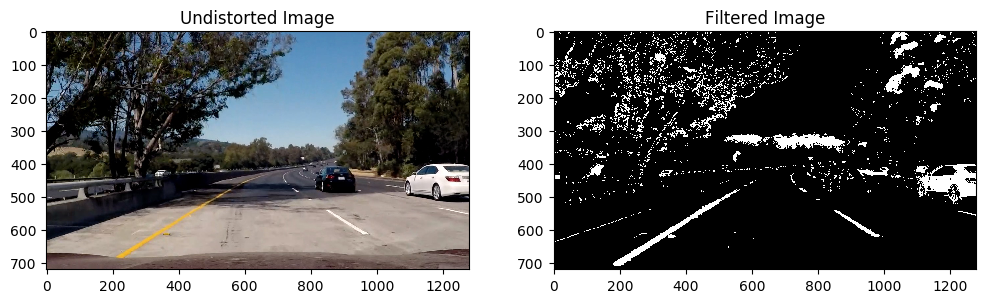

In [8]:
image_filter = ImageFilter()
binary = image_filter.apply(test_undistort)
plt.figure(figsize=(12, 4), dpi=100)
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
plt.title('Undistorted Image')
plt.subplot(1,2,2)
plt.imshow(binary, cmap='gray')
plt.title('Filtered Image')


## 3. Perspective Transform

In [27]:
class PerspectiveTransform:
    """
    Image perspective transform
    """
    def __init__(self, src=np.float32([[572, 450], [0, 720], [1280, 720],[702, 450]]), \
                       dst=np.float32([[160, 0], [160, 720], [1120, 720], [1000, 0]])):
        self.src = src
        self.dst = dst
    
    def _get_transform_matrix(self):
        matrix = cv2.getPerspectiveTransform(self.src, self.dst)
        return matrix
    
    def transform(self, image):
        height, width = image.shape[0], image.shape[1]
        M = self._get_transform_matrix()
        warped_image = cv2.warpPerspective(image, M, (width, height))
        
        return warped_image

### visualization

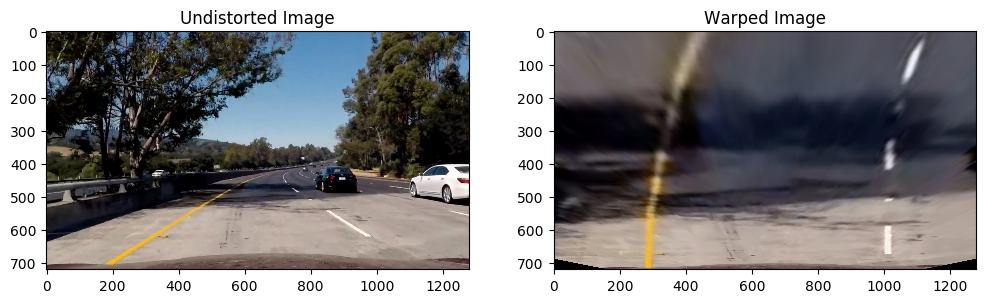

In [28]:
perspectiveTransform = PerspectiveTransform()
test_warped_image = perspectiveTransform.transform(test_undistort)
plt.figure(figsize=(12, 4), dpi=100)
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(test_undistort, cv2.COLOR_BGR2RGB))
plt.title('Undistorted Image')
plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(test_warped_image, cv2.COLOR_BGR2RGB))
plt.title('Warped Image')


## 4. Fitting Lane Lines